# Random Forest - Top model according to the SCPM of -3.64

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "S",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/209/s.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.540 (0.050)
MAE: -0.409 (0.035)
MAPE: -0.010 (0.001)
R2: 0.989 (0.002)


******
[TEST]
******
RMSE: -0.736 (0.110)
MAE: -0.562 (0.060)
MAPE: -0.014 (0.001)
R2: 0.981 (0.007)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-02,34.200001,34.424463,TRAIN
1,2021-01-04,34.700001,34.983890,TRAIN
2,2021-01-04,46.099998,44.925218,TRAIN
3,2021-01-05,45.799999,45.631016,TRAIN
4,2021-01-05,34.599998,34.983890,TRAIN
...,...,...,...,...
1490,2023-07-15,46.500000,45.843438,TEST
1491,2023-07-18,46.500000,45.956031,TEST
1492,2023-07-18,34.400002,35.509633,TEST
1493,2023-07-19,46.099998,45.956031,TEST


<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2021-01-02,34.200001,34.424463,TRAIN,CP II-Z-32
1,2021-01-04,34.700001,34.983890,TRAIN,CP II-Z-32
2,2021-01-04,46.099998,44.925218,TRAIN,CP II-F-40
3,2021-01-05,45.799999,45.631016,TRAIN,CP II-F-40
4,2021-01-05,34.599998,34.983890,TRAIN,CP II-Z-32
...,...,...,...,...,...
1490,2023-07-15,46.500000,45.843438,TEST,CP II-F-40
1491,2023-07-18,46.500000,45.956031,TEST,CP II-F-40
1492,2023-07-18,34.400002,35.509633,TEST,CP II-Z-32
1493,2023-07-19,46.099998,45.956031,TEST,CP II-F-40


<IPython.core.display.Javascript object>

In [14]:
df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

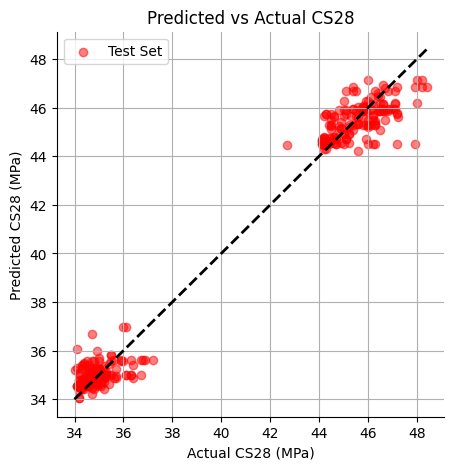

<IPython.core.display.Javascript object>

In [16]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



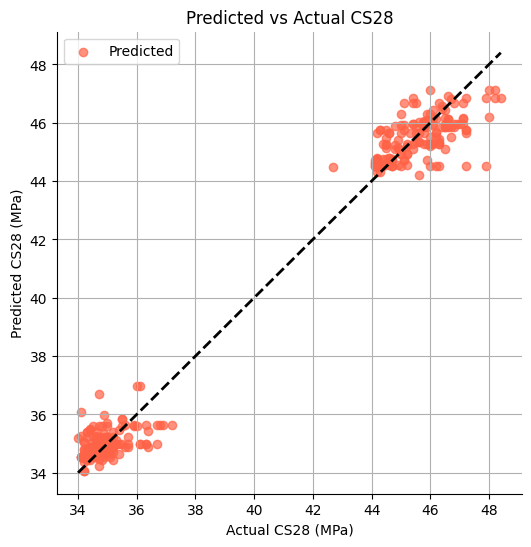

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


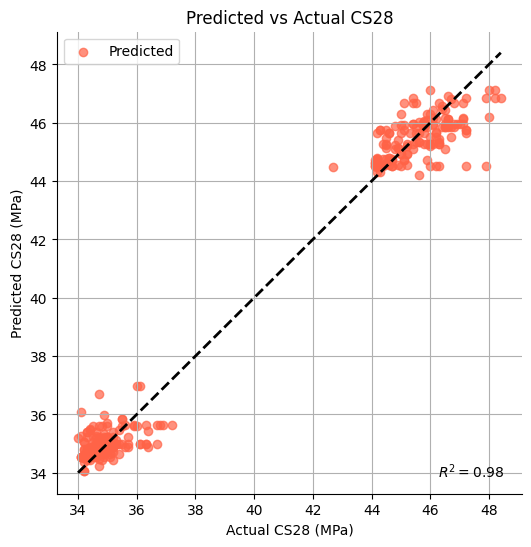

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.98
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [19]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-F-40    749
CP II-Z-32    746
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
test_data[
    (test_data["CS28"] > 34)
    & (test_data["CS28"] < 36)
    & (test_data["CS28_PRED"] > 42)
    & (test_data["CS28_PRED"] < 44)
]

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE


<IPython.core.display.Javascript object>

In [21]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    597.000000
mean      34.962144
std        0.953028
min       32.299999
25%       34.400002
50%       34.799999
75%       35.400002
max       37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [22]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    577.000000
mean      45.252513
std        0.900732
min       44.099998
25%       44.500000
50%       45.000000
75%       45.799999
max       48.599998
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

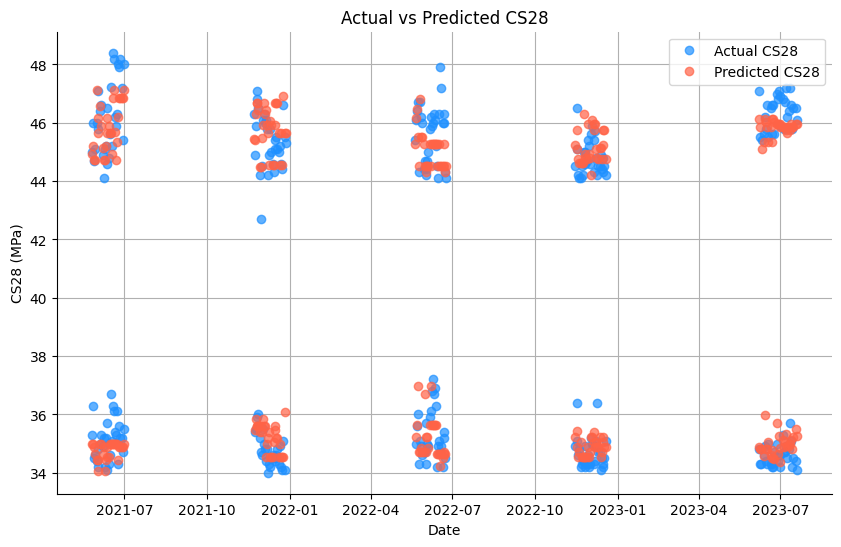

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [24]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [25]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#400,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.000000,0.000000,0.000000,0.000028,0.194221,0.000000,0.000140,0.0,0.000000,0.194415,0.000013,0.193678,0.00000,0.000000,0.197809,0.219695
Importances - 1,0.000449,0.000000,0.000126,0.000166,0.000000,0.000000,0.000000,0.000000,0.0,0.001304,0.000000,0.000000,0.393183,0.00034,0.196688,0.393868,0.013876
Importances - 2,0.000000,0.000000,0.001872,0.000000,0.195943,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.591687,0.210498
Importances - 3,0.001052,0.194567,0.000000,0.000423,0.194875,0.000554,0.000159,0.000000,0.0,0.000237,0.000453,0.000000,0.000000,0.00000,0.000000,0.390719,0.216961
Importances - 4,0.000405,0.000000,0.000142,0.000344,0.000302,0.000339,0.000000,0.000489,0.0,0.000000,0.000928,0.000000,0.000000,0.00000,0.000342,0.792007,0.204702


<IPython.core.display.Javascript object>

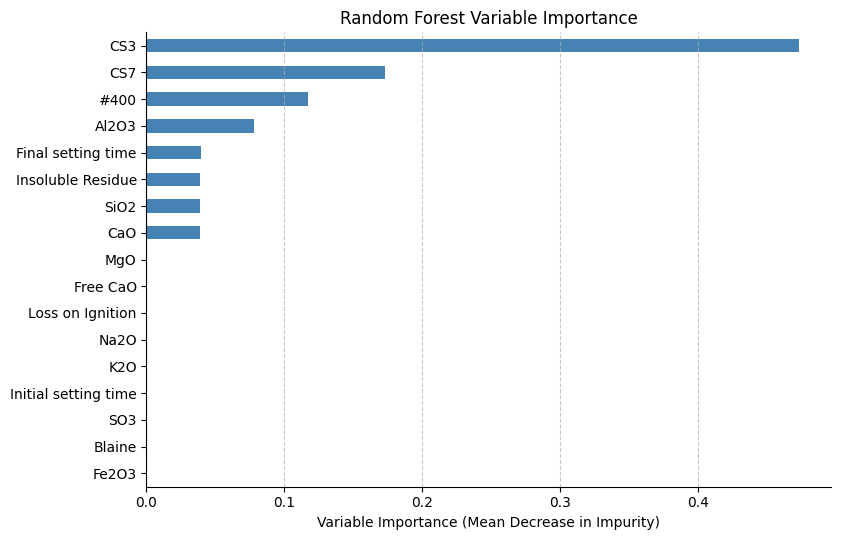

<IPython.core.display.Javascript object>

In [26]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

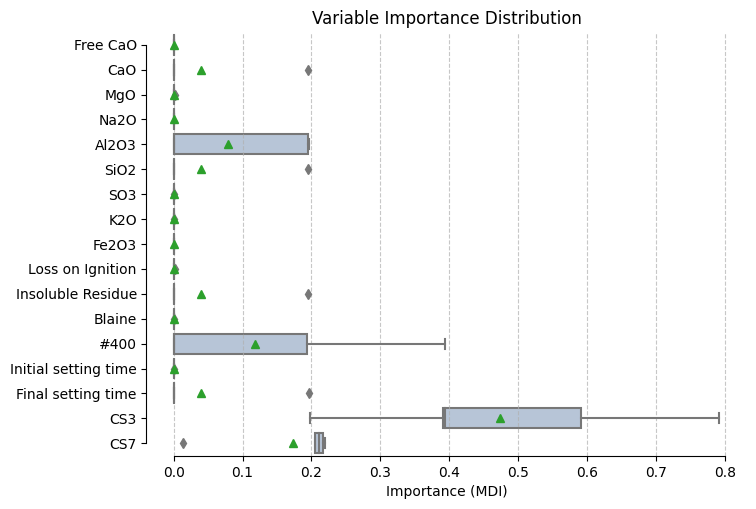

<IPython.core.display.Javascript object>

In [27]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


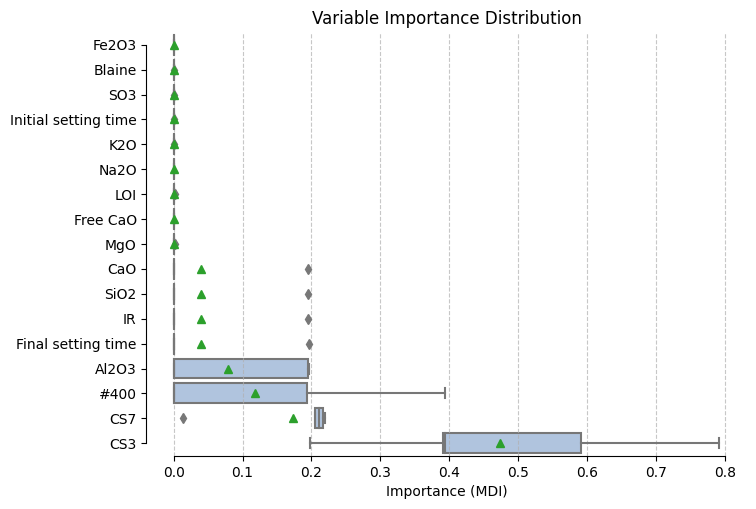

<IPython.core.display.Javascript object>

In [28]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={
        "Loss on Ignition": "LOI",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


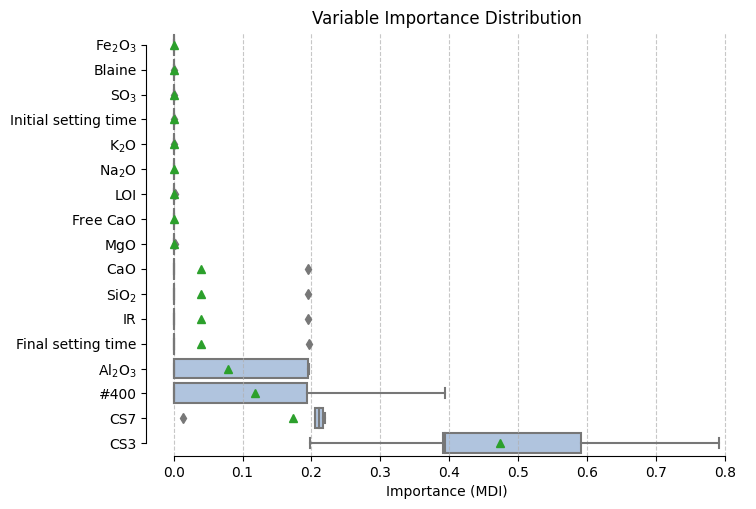

<IPython.core.display.Javascript object>

In [29]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [30]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#400,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.000000,0.000000,0.000000,0.000028,0.194221,0.000000,0.000140,0.0,0.000000,0.194415,0.000013,0.193678,0.00000,0.000000,0.197809,0.219695
Importances - 1,0.000449,0.000000,0.000126,0.000166,0.000000,0.000000,0.000000,0.000000,0.0,0.001304,0.000000,0.000000,0.393183,0.00034,0.196688,0.393868,0.013876
Importances - 2,0.000000,0.000000,0.001872,0.000000,0.195943,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.591687,0.210498
Importances - 3,0.001052,0.194567,0.000000,0.000423,0.194875,0.000554,0.000159,0.000000,0.0,0.000237,0.000453,0.000000,0.000000,0.00000,0.000000,0.390719,0.216961
Importances - 4,0.000405,0.000000,0.000142,0.000344,0.000302,0.000339,0.000000,0.000489,0.0,0.000000,0.000928,0.000000,0.000000,0.00000,0.000342,0.792007,0.204702


<IPython.core.display.Javascript object>

In [31]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Free CaO,5.0,0.000381,0.000432,0.000000,0.000000,0.000405,0.000449,0.001052
CaO,5.0,0.038913,0.087013,0.000000,0.000000,0.000000,0.000000,0.194567
MgO,5.0,0.000428,0.000810,0.000000,0.000000,0.000126,0.000142,0.001872
Na2O,5.0,0.000187,0.000194,0.000000,0.000000,0.000166,0.000344,0.000423
Al2O3,5.0,0.078230,0.106970,0.000000,0.000028,0.000302,0.194875,0.195943
SiO2,5.0,0.039023,0.086759,0.000000,0.000000,0.000339,0.000554,0.194221
SO3,5.0,0.000032,0.000071,0.000000,0.000000,0.000000,0.000000,0.000159
K2O,5.0,0.000126,0.000212,0.000000,0.000000,0.000000,0.000140,0.000489
Fe2O3,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loss on Ignition,5.0,0.000308,0.000566,0.000000,0.000000,0.000000,0.000237,0.001304


<IPython.core.display.Javascript object>

In [32]:
df_importances.mean(axis=0)

Free CaO                0.000381
CaO                     0.038913
MgO                     0.000428
Na2O                    0.000187
Al2O3                   0.078230
SiO2                    0.039023
SO3                     0.000032
K2O                     0.000126
Fe2O3                   0.000000
Loss on Ignition        0.000308
Insoluble Residue       0.039159
Blaine                  0.000003
#400                    0.117372
Initial setting time    0.000068
Final setting time      0.039406
CS3                     0.473218
CS7                     0.173146
dtype: float64

<IPython.core.display.Javascript object>

In [33]:
df_importances.std(axis=0, ddof=0)

Free CaO                0.000386
CaO                     0.077827
MgO                     0.000725
Na2O                    0.000174
Al2O3                   0.095677
SiO2                    0.077599
SO3                     0.000064
K2O                     0.000190
Fe2O3                   0.000000
Loss on Ignition        0.000506
Insoluble Residue       0.077629
Blaine                  0.000005
#400                    0.156986
Initial setting time    0.000136
Final setting time      0.078641
CS3                     0.202294
CS7                     0.079806
dtype: float64

<IPython.core.display.Javascript object>

In [34]:
df_copy.nunique()

Date                     751
Free CaO                 184
CaO                     1339
MgO                     1007
Na2O                     167
Al2O3                    874
SiO2                    1207
SO3                      513
K2O                      572
Fe2O3                    602
Loss on Ignition         341
Insoluble Residue        570
Blaine                   116
#400                     448
Initial setting time      67
Final setting time        99
CS3                      124
CS7                      145
dtype: int64

<IPython.core.display.Javascript object>

In [35]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [36]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [37]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

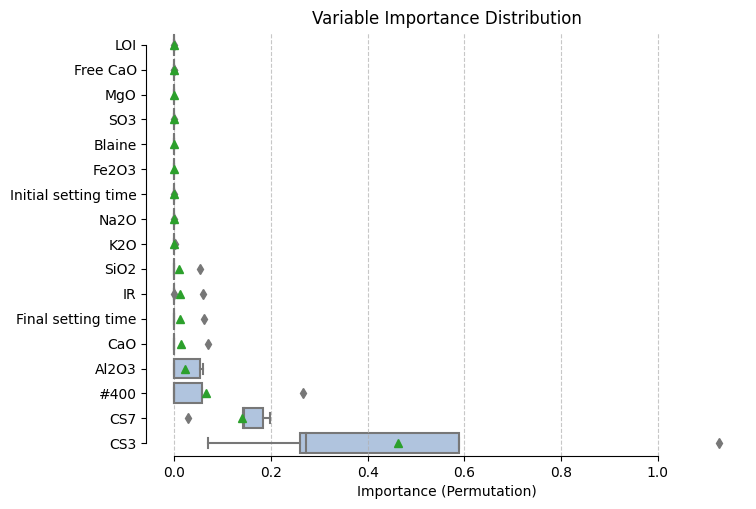

<IPython.core.display.Javascript object>

In [38]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

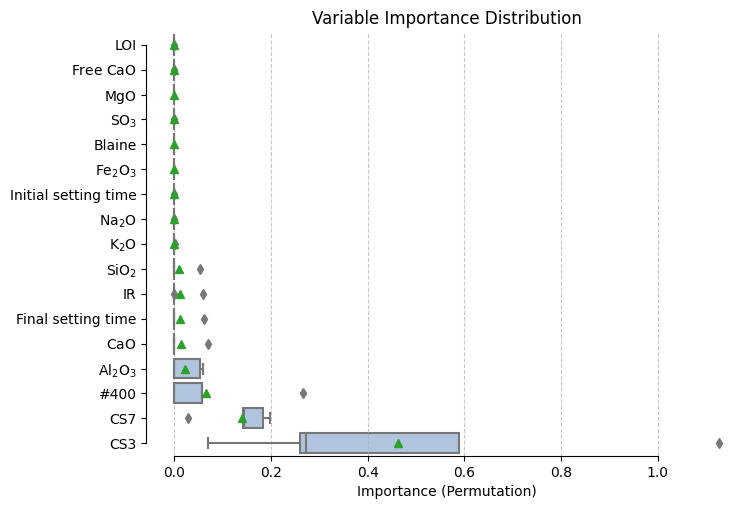

<IPython.core.display.Javascript object>

In [39]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [40]:
perm_importances_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
LOI,5.0,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
Free CaO,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
MgO,5.0,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
SO3,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Blaine,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fe2O3,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Initial setting time,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Na2O,5.0,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
K2O,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SiO2,5.0,0.01,0.02,-0.00,-0.00,0.00,0.00,0.05


<IPython.core.display.Javascript object>

In [41]:
perm_importances_df

,LOI,Free CaO,MgO,SO3,Blaine,Fe2O3,Initial setting time,Na2O,K2O,SiO2,IR,Final setting time,CaO,Al2O3,#400,CS7,CS3
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.052644,0.059464,0.000000e+00,0.000000,0.000000,0.057248,0.198705,0.070366
1,-0.001144,0.000266,-0.000126,0.000000,0.0,0.0,0.000012,0.000049,0.000000,0.000000,0.000000,6.193305e-02,0.000000,0.000000,0.266753,0.027790,0.259636
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.059078,0.000000,0.142074,0.588390
3,-0.000076,0.000073,0.000000,-0.000002,0.0,0.0,0.000000,0.000416,0.000000,-0.000747,0.000303,0.000000e+00,0.069232,0.052936,0.000000,0.182514,0.272199
4,0.000000,-0.000852,-0.000182,0.000000,0.0,0.0,0.000000,-0.000025,0.001294,-0.000639,-0.000960,7.260557e-07,0.000000,0.000037,0.000000,0.144659,1.127199


<IPython.core.display.Javascript object>

In [42]:
perm_importances_df.mean(axis=0)

LOI                    -2.439359e-04
Free CaO               -1.025626e-04
MgO                    -6.166915e-05
SO3                    -4.432459e-07
Blaine                  0.000000e+00
Fe2O3                   0.000000e+00
Initial setting time    2.432159e-06
Na2O                    8.787255e-05
K2O                     2.587915e-04
SiO2                    1.025168e-02
IR                      1.176121e-02
Final setting time      1.238676e-02
CaO                     1.384631e-02
Al2O3                   2.241028e-02
#400                    6.480009e-02
CS7                     1.391485e-01
CS3                     4.635580e-01
dtype: float64

<IPython.core.display.Javascript object>

In [43]:
perm_importances_df.std(axis=0, ddof=0)

LOI                     4.508604e-04
Free CaO                3.871356e-04
MgO                     7.760901e-05
SO3                     8.864917e-07
Blaine                  0.000000e+00
Fe2O3                   0.000000e+00
Initial setting time    4.864319e-06
Na2O                    1.656578e-04
K2O                     5.175829e-04
SiO2                    2.119823e-02
IR                      2.385501e-02
Final setting time      2.477315e-02
CaO                     2.769263e-02
Al2O3                   2.750050e-02
#400                    1.033819e-01
CS7                     5.977829e-02
CS3                     3.711616e-01
dtype: float64

<IPython.core.display.Javascript object>

In [44]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>

In [45]:
perm_importances_df.drop(perm_importances_df["Blaine"].idxmax()).describe().T

,count,mean,std,min,25%,50%,75%,max
LOI,4.0,-3.049198e-04,0.000560,-0.001144,-3.428916e-04,-3.797174e-05,0.000000,0.000000
Free CaO,4.0,-1.282032e-04,0.000495,-0.000852,-2.129682e-04,3.629102e-05,0.000121,0.000266
MgO,4.0,-7.708644e-05,0.000092,-0.000182,-1.400632e-04,-6.297680e-05,0.000000,0.000000
SO3,4.0,-5.540573e-07,0.000001,-0.000002,-5.540573e-07,0.000000e+00,0.000000,0.000000
Blaine,4.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
Fe2O3,4.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
Initial setting time,4.0,3.040199e-06,0.000006,0.000000,0.000000e+00,0.000000e+00,0.000003,0.000012
Na2O,4.0,1.098407e-04,0.000206,-0.000025,-6.263993e-06,2.435077e-05,0.000140,0.000416
K2O,4.0,3.234893e-04,0.000647,0.000000,0.000000e+00,0.000000e+00,0.000323,0.001294
SiO2,4.0,-3.462877e-04,0.000402,-0.000747,-6.655417e-04,-3.192540e-04,0.000000,0.000000


<IPython.core.display.Javascript object>

# Linear Regression - Top model according to the SCPM of -3.64

In [46]:
# Modeling
from sklearn.linear_model import LinearRegression

<IPython.core.display.Javascript object>

In [47]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [48]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "K",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

In [49]:
df = pd.read_csv("../../../../data/processed/209/k.csv")

<IPython.core.display.Javascript object>

In [50]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

In [51]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [52]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.693 (0.084)
MAE: -0.526 (0.066)
MAPE: -0.012 (0.002)
R2: 0.987 (0.004)


******
[TEST]
******
RMSE: -0.764 (0.165)
MAE: -0.566 (0.125)
MAPE: -0.013 (0.003)
R2: 0.979 (0.015)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [53]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [54]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-02,38.900002,38.405992,TRAIN
1,2021-01-04,48.500000,49.522421,TRAIN
2,2021-01-04,36.500000,37.284472,TRAIN
3,2021-01-04,36.299999,36.884530,TRAIN
4,2021-01-04,55.599998,55.324922,TRAIN
...,...,...,...,...
3340,2023-07-17,46.200001,46.346062,TEST
3341,2023-07-18,44.700001,45.867022,TEST
3342,2023-07-19,45.700001,46.672197,TEST
3343,2023-07-20,47.799999,47.281474,TEST


<IPython.core.display.Javascript object>

In [55]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2021-01-02,38.900002,38.405992,TRAIN,CP II-F-32
1,2021-01-04,48.500000,49.522421,TRAIN,CP II-F-40
2,2021-01-04,36.500000,37.284472,TRAIN,CP IV-32
3,2021-01-04,36.299999,36.884530,TRAIN,CP II-F-32
4,2021-01-04,55.599998,55.324922,TRAIN,CP V-ARI
...,...,...,...,...,...
3340,2023-07-17,46.200001,46.346062,TEST,CP II-F-40
3341,2023-07-18,44.700001,45.867022,TEST,CP II-F-40
3342,2023-07-19,45.700001,46.672197,TEST,CP II-F-40
3343,2023-07-20,47.799999,47.281474,TEST,CP II-F-40


<IPython.core.display.Javascript object>

In [56]:
df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [57]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

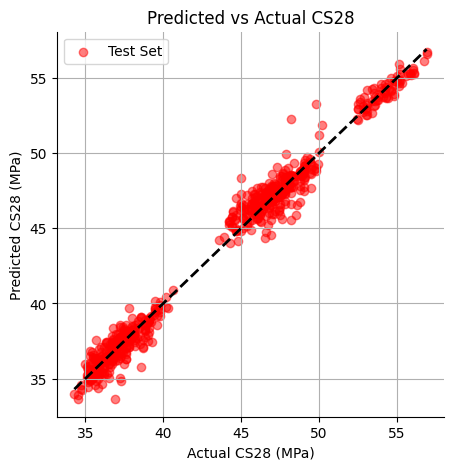

<IPython.core.display.Javascript object>

In [58]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_linear_regression_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



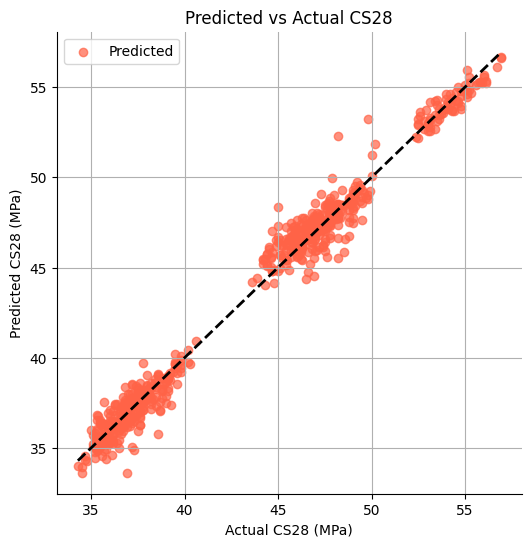

<IPython.core.display.Javascript object>

In [59]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_linear_regression_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


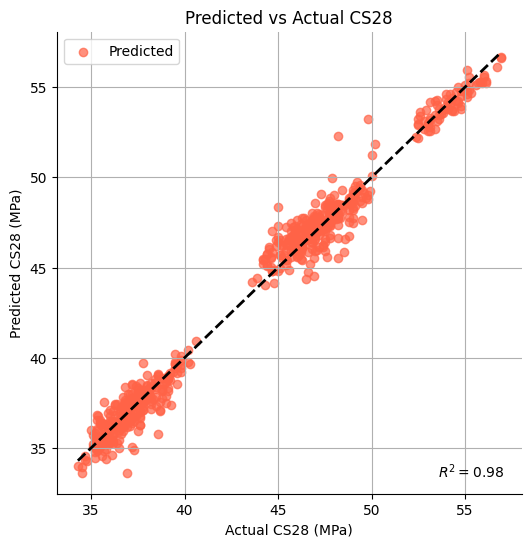

<IPython.core.display.Javascript object>

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.98
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig("ecics_cm_p_cs_btiss_scpm_top_one_linear_regression_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [61]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-F-40    1526
CP II-F-32     718
CP IV-32       661
CP V-ARI       440
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [62]:
df[df["Cement_Type"].eq("CP V-ARI")]["CS28"].describe()

count    440.000000
mean      54.443863
std        1.502029
min       47.599998
25%       53.475000
50%       54.350000
75%       55.500000
max       58.299999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [63]:
test_data[
    (test_data["CS28"] > 34)
    & (test_data["CS28"] < 36)
    & (test_data["CS28_PRED"] > 42)
    & (test_data["CS28_PRED"] < 44)
]

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE


<IPython.core.display.Javascript object>

In [64]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    677.000000
mean      36.425849
std        0.899143
min       34.000000
25%       35.799999
50%       36.599998
75%       37.099998
max       37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [65]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    1582.000000
mean       49.148862
std         3.224222
min        44.099998
25%        47.000000
50%        48.099998
75%        49.900000
max        58.299999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

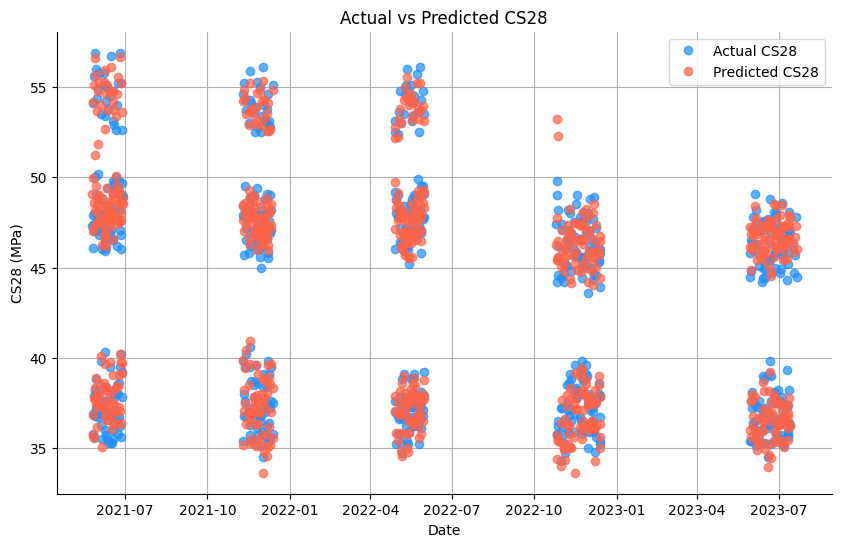

<IPython.core.display.Javascript object>

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_btiss_scpm_top_one_linear_regression_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [67]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [68]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time,CS3,CS7
Coefficients - 0,0.147760,-0.020030,-0.057212,0.259262,-0.078983,-0.024918,-0.690796,0.018079,-0.519358,0.259680,0.090127,-0.758037,-0.206475,0.082511,0.703899,4.638001
Coefficients - 1,-0.463967,-0.092586,0.035454,0.166059,0.312523,-0.033494,-0.408550,0.022983,-0.145600,-1.177037,0.037912,-0.819820,-0.038978,0.089500,-0.534379,5.377180
Coefficients - 2,0.258597,0.021349,-0.024707,0.160563,-0.154902,0.026650,0.086250,0.012742,-0.619538,-0.413470,0.130508,-0.644990,-0.071173,0.030031,0.856961,4.209402
Coefficients - 3,0.563832,-0.008885,-0.028156,-0.150685,0.473663,0.005508,0.778842,0.015682,0.120588,-0.022562,-0.094662,-0.100810,-0.014592,0.044148,0.949249,5.642459
Coefficients - 4,0.165167,0.083655,-0.053316,0.143698,-0.099313,0.072044,-0.106987,0.032747,-0.455472,-0.123788,0.041075,-0.351518,-0.087446,-0.010170,0.711012,4.003021


<IPython.core.display.Javascript object>

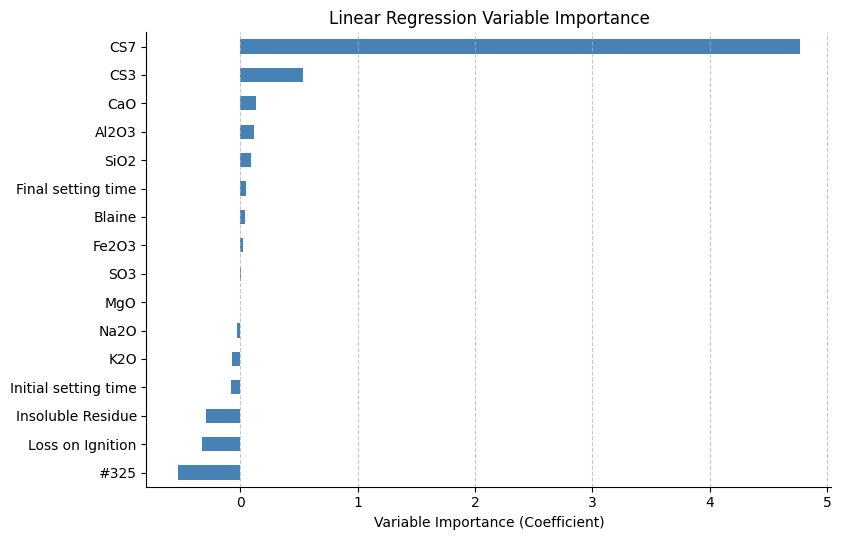

<IPython.core.display.Javascript object>

In [69]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Importance")
plt.xlabel("Variable Importance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

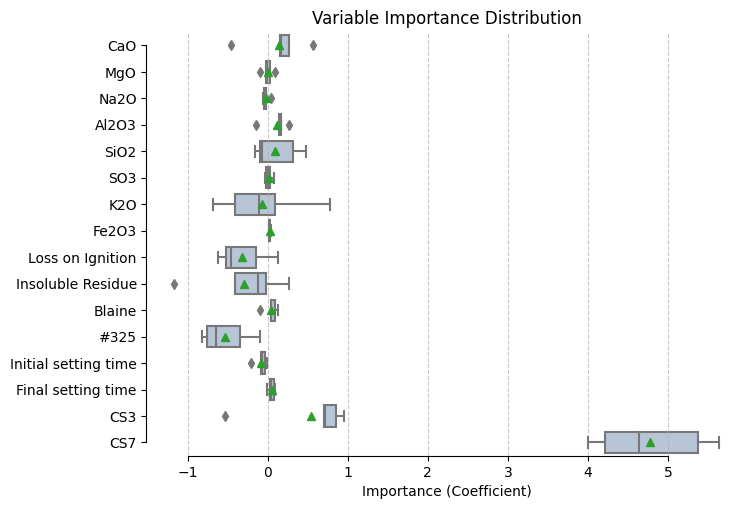

<IPython.core.display.Javascript object>

In [70]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


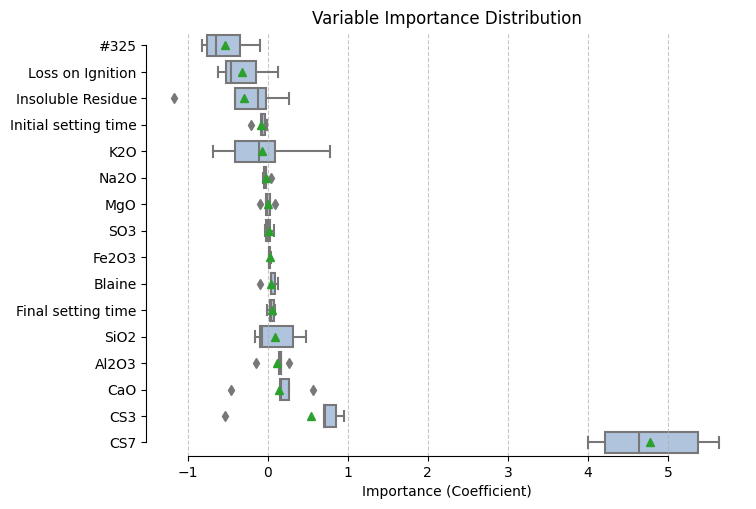

<IPython.core.display.Javascript object>

In [71]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
# df_importances_sorted = df_importances_sorted.rename(
#    columns={"Loss on Ignition": "LOI"}
# )

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted.rename(
        {"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
    ),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [72]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [73]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

In [74]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Importance Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

<IPython.core.display.Javascript object>

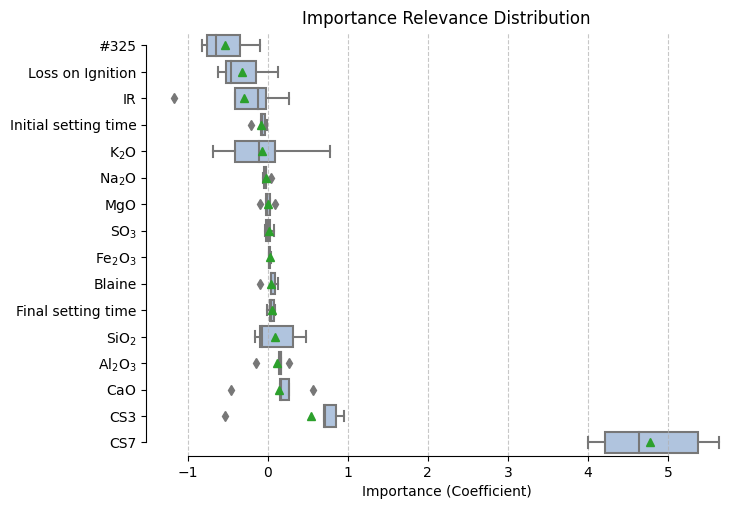

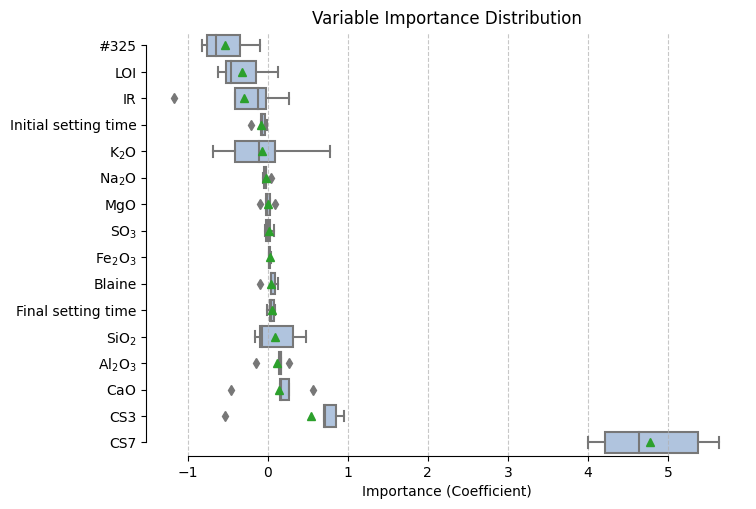

<IPython.core.display.Javascript object>

In [75]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Coefficient)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [76]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time,CS3,CS7
Coefficients - 0,0.147760,-0.020030,-0.057212,0.259262,-0.078983,-0.024918,-0.690796,0.018079,-0.519358,0.259680,0.090127,-0.758037,-0.206475,0.082511,0.703899,4.638001
Coefficients - 1,-0.463967,-0.092586,0.035454,0.166059,0.312523,-0.033494,-0.408550,0.022983,-0.145600,-1.177037,0.037912,-0.819820,-0.038978,0.089500,-0.534379,5.377180
Coefficients - 2,0.258597,0.021349,-0.024707,0.160563,-0.154902,0.026650,0.086250,0.012742,-0.619538,-0.413470,0.130508,-0.644990,-0.071173,0.030031,0.856961,4.209402
Coefficients - 3,0.563832,-0.008885,-0.028156,-0.150685,0.473663,0.005508,0.778842,0.015682,0.120588,-0.022562,-0.094662,-0.100810,-0.014592,0.044148,0.949249,5.642459
Coefficients - 4,0.165167,0.083655,-0.053316,0.143698,-0.099313,0.072044,-0.106987,0.032747,-0.455472,-0.123788,0.041075,-0.351518,-0.087446,-0.010170,0.711012,4.003021


<IPython.core.display.Javascript object>

In [77]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
#325,5.0,-0.535035,0.302139,-0.819820,-0.758037,-0.644990,-0.351518,-0.100810
Loss on Ignition,5.0,-0.323876,0.305073,-0.619538,-0.519358,-0.455472,-0.145600,0.120588
Insoluble Residue,5.0,-0.295435,0.548459,-1.177037,-0.413470,-0.123788,-0.022562,0.259680
Initial setting time,5.0,-0.083733,0.074197,-0.206475,-0.087446,-0.071173,-0.038978,-0.014592
K2O,5.0,-0.068248,0.558190,-0.690796,-0.408550,-0.106987,0.086250,0.778842
Na2O,5.0,-0.025587,0.037089,-0.057212,-0.053316,-0.028156,-0.024707,0.035454
MgO,5.0,-0.003299,0.064132,-0.092586,-0.020030,-0.008885,0.021349,0.083655
SO3,5.0,0.009158,0.042586,-0.033494,-0.024918,0.005508,0.026650,0.072044
Fe2O3,5.0,0.020446,0.007832,0.012742,0.015682,0.018079,0.022983,0.032747
Blaine,5.0,0.040992,0.084910,-0.094662,0.037912,0.041075,0.090127,0.130508


<IPython.core.display.Javascript object>

In [78]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [79]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

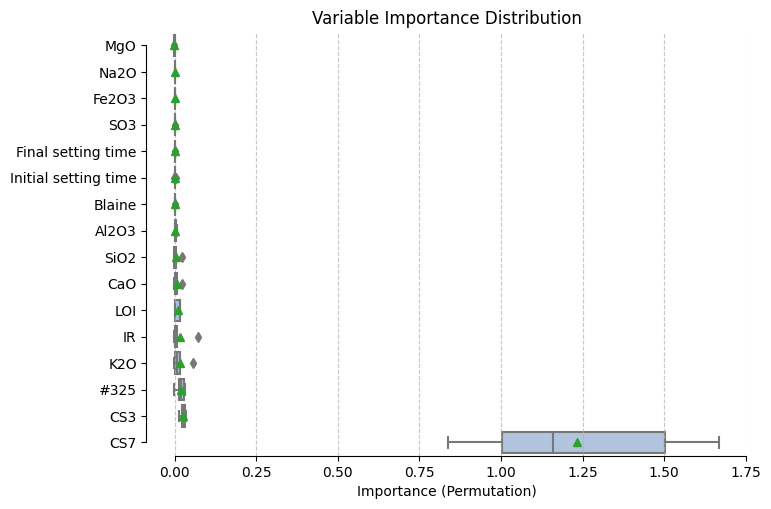

<IPython.core.display.Javascript object>

In [80]:
# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

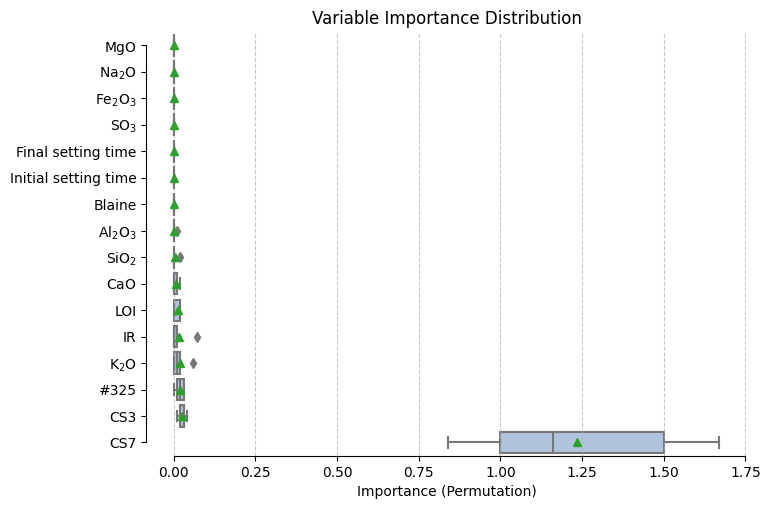

<IPython.core.display.Javascript object>

In [81]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

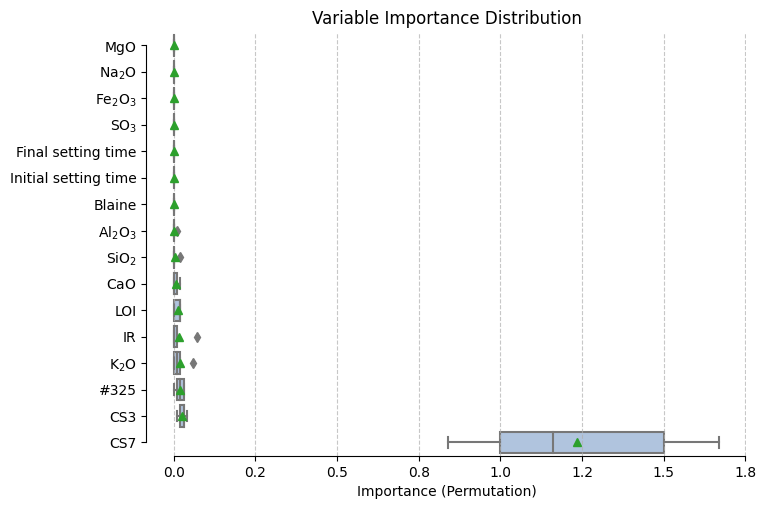

<IPython.core.display.Javascript object>

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_cm_p_cs_btiss_linear_regression_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [83]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
MgO,5.0,-0.0003,0.0003,-0.0008,-0.0004,-0.0001,-0.0001,-0.0000
Na2O,5.0,-0.0000,0.0002,-0.0002,-0.0001,0.0000,0.0000,0.0002
Fe2O3,5.0,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0001,0.0001
SO3,5.0,0.0002,0.0004,-0.0001,-0.0000,0.0000,0.0002,0.0009
Final setting time,5.0,0.0002,0.0005,-0.0002,-0.0000,-0.0000,0.0003,0.0011
Initial setting time,5.0,0.0004,0.0018,-0.0015,-0.0002,0.0002,0.0003,0.0034
Blaine,5.0,0.0007,0.0009,-0.0000,0.0003,0.0004,0.0008,0.0023
Al2O3,5.0,0.0027,0.0023,0.0001,0.0016,0.0018,0.0039,0.0060
SiO2,5.0,0.0049,0.0096,-0.0013,-0.0003,0.0007,0.0037,0.0218
CaO,5.0,0.0062,0.0092,-0.0023,0.0009,0.0035,0.0075,0.0213


<IPython.core.display.Javascript object>

In [84]:
perm_importances_df

,MgO,Na2O,Fe2O3,SO3,Final setting time,Initial setting time,Blaine,Al2O3,SiO2,CaO,LOI,IR,K2O,#325,CS3,CS7
0,-0.000058,-0.000204,0.000133,0.000159,-0.000032,0.003372,-0.000045,0.003919,-0.000314,0.000944,0.016866,0.001934,0.018064,0.028779,0.027980,1.002954
1,-0.000356,0.000179,0.000008,-0.000132,0.000289,0.000153,0.000268,0.000113,0.003740,0.007514,0.000428,0.071354,0.008034,0.032059,0.014050,1.503242
2,-0.000017,0.000010,0.000022,0.000003,-0.000004,0.000301,0.000783,0.001824,0.000684,0.003505,0.017474,0.007883,0.000505,0.021176,0.035864,0.838650
3,-0.000142,0.000038,-0.000101,-0.000043,0.001087,-0.000238,0.002338,0.001598,0.021775,0.021299,0.002300,-0.000211,0.056937,-0.001379,0.032404,1.668533
4,-0.000831,-0.000136,0.000138,0.000944,-0.000171,-0.001515,0.000403,0.005995,-0.001276,-0.002308,0.017240,-0.002563,-0.002580,0.012016,0.022833,1.158639


<IPython.core.display.Javascript object>